In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import xgboost as xgb

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_pickle('person_purchased.pkl')
df1.shape

(7695, 23)

In [3]:
df2 = pd.read_pickle('person_not.pkl')
df2.shape

(260046, 23)

In [4]:
df = pd.concat([df1, df2], axis=0)

In [5]:
df.shape

(267741, 23)

In [6]:
df["has_purchased"].value_counts()

0    260046
1      7695
Name: has_purchased, dtype: int64

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267741 entries, 0 to 260045
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   person_id                   267741 non-null  object 
 1   first_utm_medium            190136 non-null  object 
 2   first_utm_source            190148 non-null  object 
 3   multi_device                267741 non-null  int64  
 4   session_count               267741 non-null  int64  
 5   last_utm_medium             198480 non-null  object 
 6   last_utm_source             198492 non-null  object 
 7   source_category             267741 non-null  object 
 8   source_category_2           158478 non-null  object 
 9   source_category_3           32656 non-null   object 
 10  seconds_since_first_vist    267741 non-null  float64
 11  first_utm_content_distinct  267741 non-null  int64  
 12  first_utm_medium_distinct   267741 non-null  int64  
 13  first_utm_sour

## Pearson's Correlation Heatmap

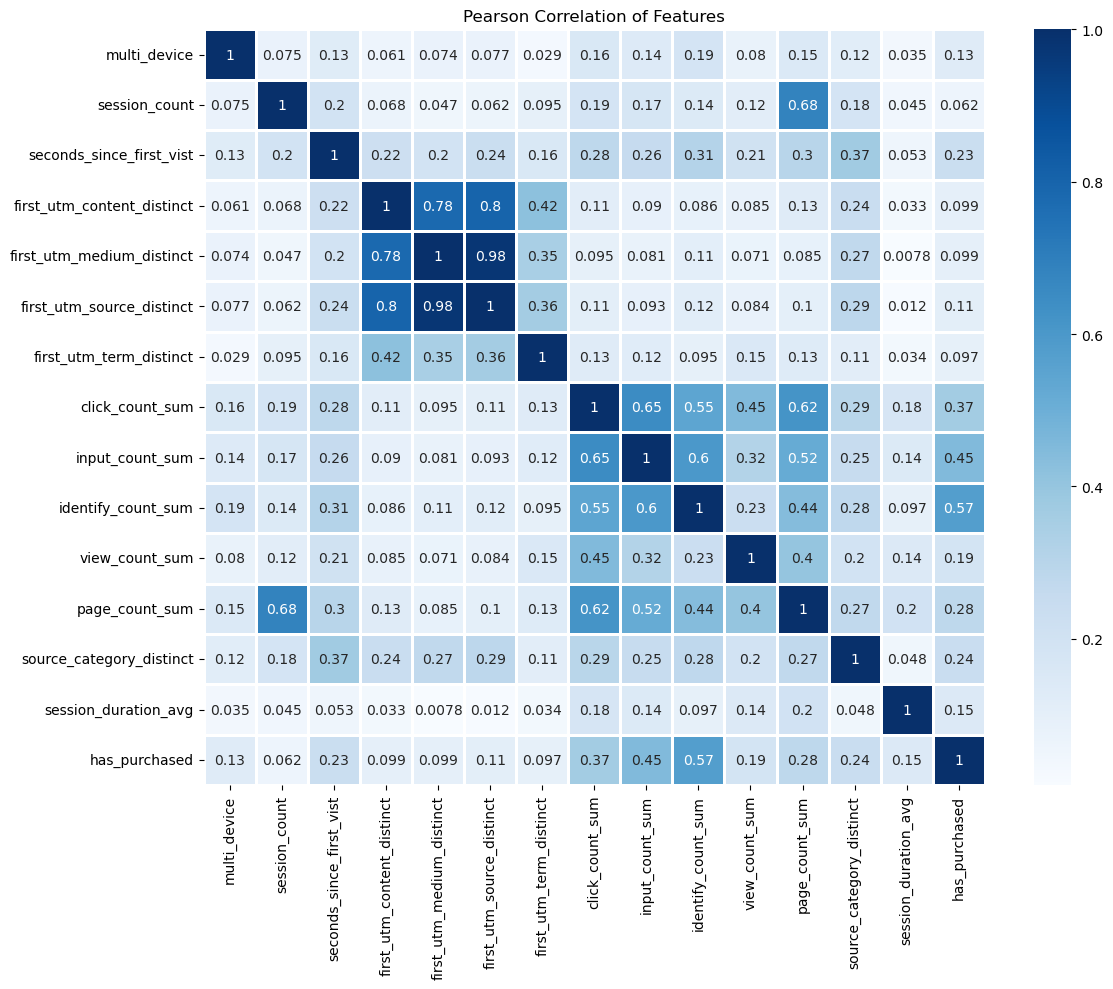

In [8]:
corr = df.corr(numeric_only=True)

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax,  linewidth = 1)
plt.title('Pearson Correlation of Features')
plt.tight_layout()
plt.savefig('02_correlation_matrix.png', dpi=300);

In [9]:
df_y = df['has_purchased']
df_X = df.drop(columns=['has_purchased', 'person_id'])

### Show an Example Record

In [25]:
df_X.iloc[1]

first_utm_medium                     sfmc
first_utm_source                    email
multi_device                            0
session_count                           5
last_utm_medium                google_ads
last_utm_source                    search
source_category               Direct Mail
source_category_2                    None
source_category_3                    None
seconds_since_first_vist      8579287.456
first_utm_content_distinct              1
first_utm_medium_distinct               2
first_utm_source_distinct               2
first_utm_term_distinct                 1
click_count_sum                        59
input_count_sum                         2
identify_count_sum                     11
view_count_sum                          0
page_count_sum                         55
source_category_distinct                4
session_duration_avg                  9.0
Name: 1, dtype: object

## Preprocessing

In [12]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [13]:
# count examples in each class
counter = Counter(df_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 33.794


In [14]:
def create_pipe(clf):

    column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_include='number')),
        ('cat', OneHotEncoder(dtype='int', handle_unknown='ignore'), selector(dtype_include="object"))],
        remainder='passthrough', verbose_feature_names_out=True)

    pipeline = Pipeline([('prep',column_trans), ('clf', clf)])

    return pipeline

## Evaluate Final Model

In [15]:
clf = xgb.XGBClassifier(random_state=42, 
                        verbosity=0, 
                        objective='binary:logistic',
                        scale_pos_weight=estimate,
                        n_estimators=1000, 
                        max_depth=6, 
                        learning_rate=0.5)

pipeline = create_pipe(clf)

In [16]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
        
    Source: https://johaupt.github.io/blog/columnTransformer_feature_names.html
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names_out'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names_out. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names_out()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x287590b20>),
                                                 ('cat',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x287590a30>)])),
                ('clf',
                 XGBClassifier(base_sco...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.5,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, ...))])

In [30]:
feat_list = []
xgb_cols = get_feature_names(pipeline['prep'])
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(10)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
9,num__identify_count_sum,0.518808,0.518808
144,cat__source_category_Email,0.040660,0.559468
88,cat__last_utm_medium_criteo,0.037895,0.597363
161,cat__source_category_2_Retargeting,0.019294,0.616657
162,cat__source_category_2_Retention,0.017467,0.634124
61,cat__first_utm_source_email,0.014482,0.648606
160,cat__source_category_2_Reactivation,0.013840,0.662445
11,num__page_count_sum,0.013448,0.675893
163,cat__source_category_2_SMS,0.012081,0.687974
152,cat__source_category_2_Facebook,0.011446,0.699420


In [19]:
df_imp.to_csv('02_xgb_feature_importance.csv', index=False)

## Test the Model

In [20]:
def print_confusion(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
        
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('02_confusion_matrix.png', dpi=300);

              precision    recall  f1-score   support

           0      0.997     0.995     0.996     77963
           1      0.839     0.902     0.869      2360

    accuracy                          0.992     80323
   macro avg      0.918     0.948     0.933     80323
weighted avg      0.992     0.992     0.992     80323



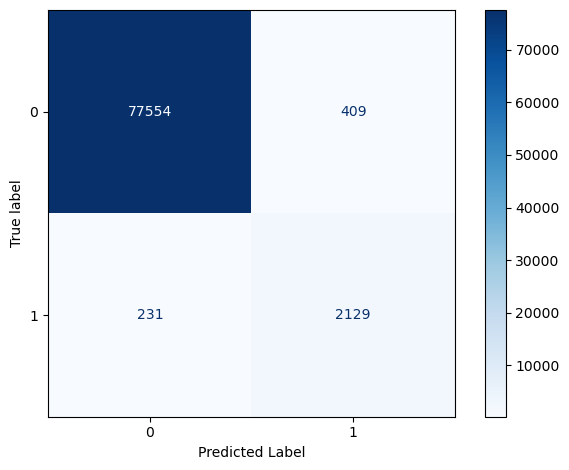

In [21]:
print_confusion(pipeline)

In [31]:
# Save the model to disk
dump(pipeline, '02_tf_first_purchase.joblib') 

['02_tf_first_purchase.joblib']